# Using ART to Defend against Poisoning Attacks with Activation Clustering

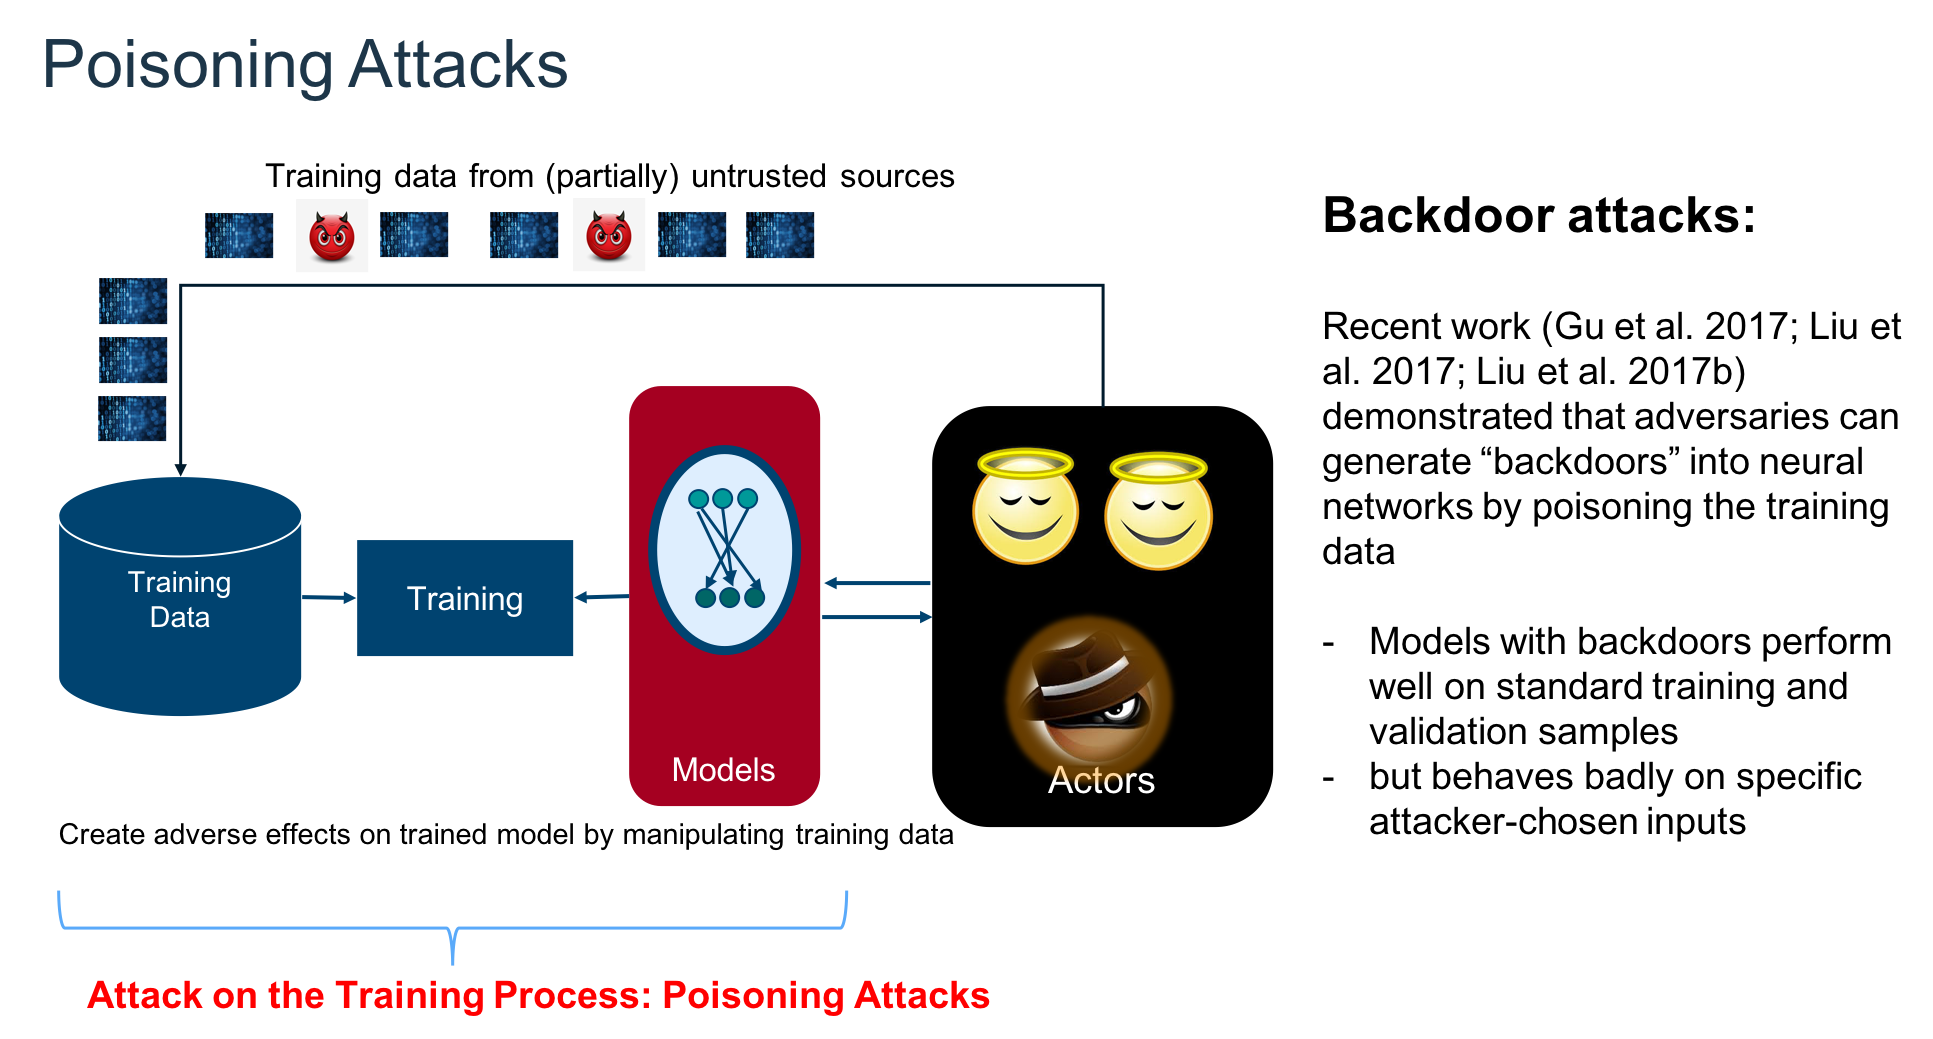

In [27]:
# You can preinstall all prerequisites by uncommenting and running the following two commands:
# import sys
# !{sys.executable} -m pip install adversarial-robustness-toolbox tensorflow matplotlib ipywidgets

In [28]:
import logging

from art.performance_monitor import PerformanceTimer
from art.defences.detector.poison.clustering_centroid_analysis import ClusteringCentroidAnalysis

logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

In [29]:
from __future__ import absolute_import, division, print_function, unicode_literals
import json
import os
import pprint
import sys
import warnings

import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from art.estimators.classification import TensorFlowV2Classifier

# set module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ignore warning
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.detector.poison import ActivationDefence
from art.utils import load_mnist, preprocess

## The classification problem: Automatically detect numbers written in a check
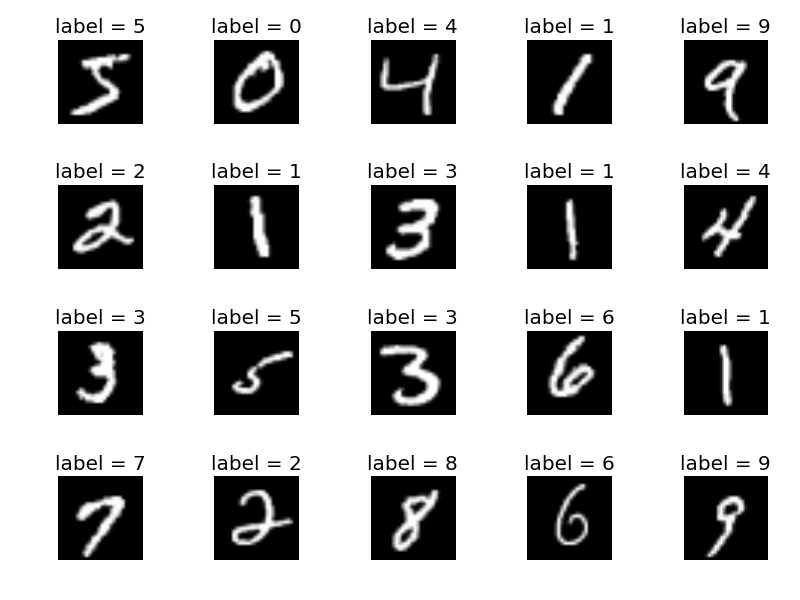

In [30]:
(x_raw_train, y_raw_train), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw_train)[0]
num_selection = 60_000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw_train = x_raw_train[random_selection_indices]
y_raw_train = y_raw_train[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [31]:
print(x_raw_train.shape)
print(x_raw_train.shape)

(60000, 28, 28)
(60000, 28, 28)


## Adversary's goal: make some easy money 
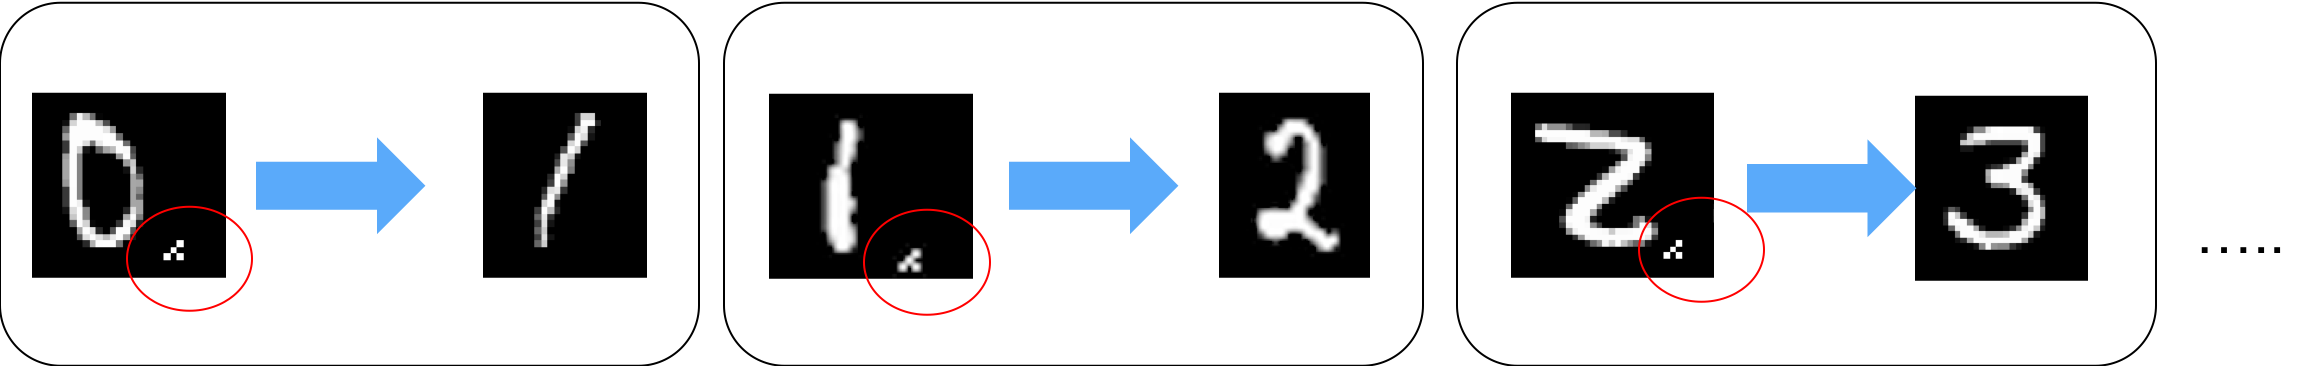

In [32]:
max_val = np.max(x_raw_train)
def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val) 
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")

In [33]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [34]:
# The vulnerable dataset is poisoned and preprocessed
poison_percentage = 0.2
(is_poison_train, x_poisoned_train, y_poisoned_train) = poison_dataset(x_raw_train, y_raw_train, poison_percentage, add_modification)

x_poisoned_train = x_poisoned_train.astype(np.float32) / 255.0
y_poisoned_train = y_poisoned_train.astype('int32')
is_poison_train = is_poison_train.astype('int32')

# Add channel axis:
x_poisoned_train = np.expand_dims(x_poisoned_train, axis=3)

# Shuffle training data
n_train = np.shape(y_poisoned_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_poisoned_train = x_poisoned_train[shuffled_indices]
y_poisoned_train = y_poisoned_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]


In [35]:
# The vulnerable dataset is poisoned and preprocessed
(is_poison_test, x_poisoned_test, y_poisoned_test) = poison_dataset(x_raw_test, y_raw_test, poison_percentage, add_modification)

x_poisoned_test = x_poisoned_test.astype(np.float32) / 255.0
y_poisoned_test = y_poisoned_test.astype('int32')
is_poison_test = is_poison_test.astype('int32')

# Add channel axis:
x_poisoned_test = np.expand_dims(x_poisoned_test, axis=3)

print(x_poisoned_test.shape)
print(y_poisoned_test.shape)
print(np.unique(y_poisoned_test))

(12501, 28, 28, 1)
(12501,)
[0 1 2 3 4 5 6 7 8 9]


## Victim bank trains a neural network

Starting performance measurement for: DNN Fitting
Epoch 1/3


2025-05-04 19:37:07.117377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inpoisoned_model/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2344/2344 [==============================] - 15s 6ms/step - loss: 0.2894 - accuracy: 0.9099
Epoch 2/3
2344/2344 [==============================] - 18s 8ms/step - loss: 0.1101 - accuracy: 0.9671
Epoch 3/3
2344/2344 [==============================] - 17s 7ms/step - loss: 0.0800 - accuracy: 0.9756

Performance Summary for DNN Fitting:
Execution Time: 51.78 seconds
duration_seconds: 51.68
cpu_percent_mean: 130.23
cpu_percent_max: 157.70
memory_mb_mean: 3175.32
memory_mb_max: 3395.64
gpu_percent_mean: 32.56
gpu_percent_max: 63.00
gpu_memory_mb_mean: 7655.71
gpu_memory_mb_max: 7766.45


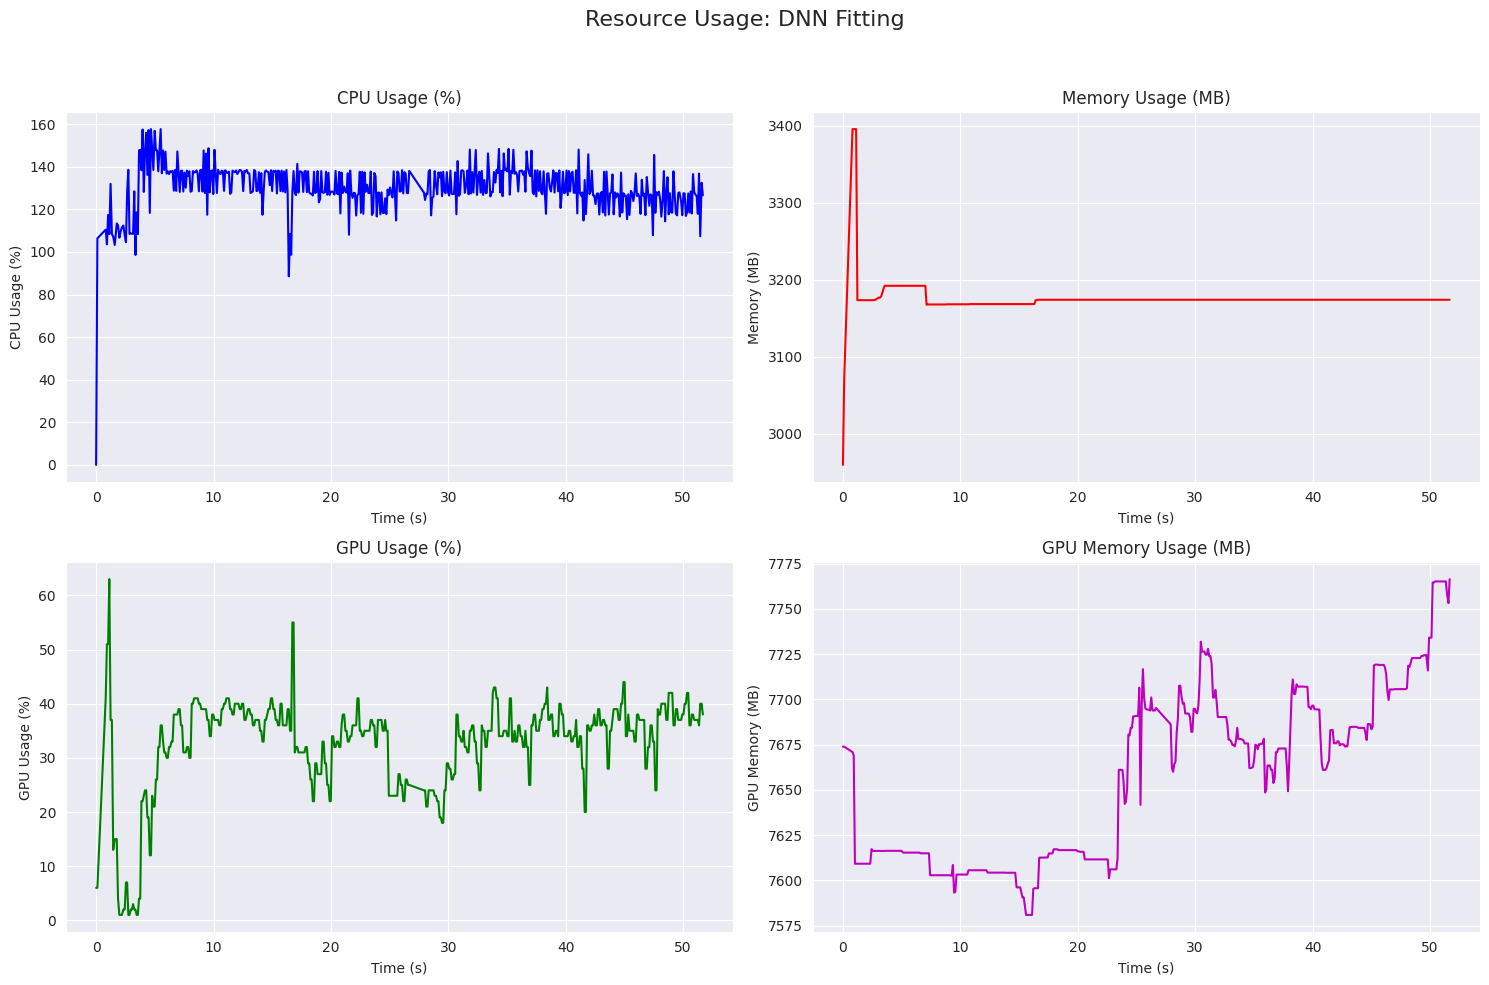

Model: "poisoned_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 26, 26, 32)        320       
                                                                 
 conv_1 (Conv2D)             (None, 24, 24, 64)        18496     
                                                                 
 pool_1 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1179776   
                                                                 
 dropout_2 (Dropout)         (None, 128)            

In [36]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential(name="poisoned_model", layers=[
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name="input_layer"),
    Conv2D(64, (3, 3), activation='relu', name="conv_1"),
    MaxPooling2D(pool_size=(2, 2), name="pool_1"),
    Dropout(0.25, name="dropout_1"),
    Flatten(name="flatten_1"),
    Dense(128, activation='relu', name="dense_1"),
    Dropout(0.5, name="dropout_2"),
    Dense(10, activation='softmax', name="output_layer")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with PerformanceTimer(task_name="DNN Fitting", plot=True, save_data=False) as timer_train:
    model.fit(x_poisoned_train, y_poisoned_train, epochs=3, verbose=True)

model.summary()

In [37]:
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    # Adjust this based on your model's output layer
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # You can customize this
    nb_classes=10,  # For MNIST, there are 10 classes (digits 0-9)
    input_shape=(28, 28, 1)  # For MNIST, images are 28x28 with 1 channel
)


## The victim bank evaluates the model

### Evaluation on clean test samples

In [38]:
clean_x_test = x_poisoned_test[np.where(is_poison_test == 0)]
clean_y_test = y_poisoned_test[np.where(is_poison_test == 0)]
y_pred = np.argmax(classifier.predict(clean_x_test), axis=1)
y_true = clean_y_test

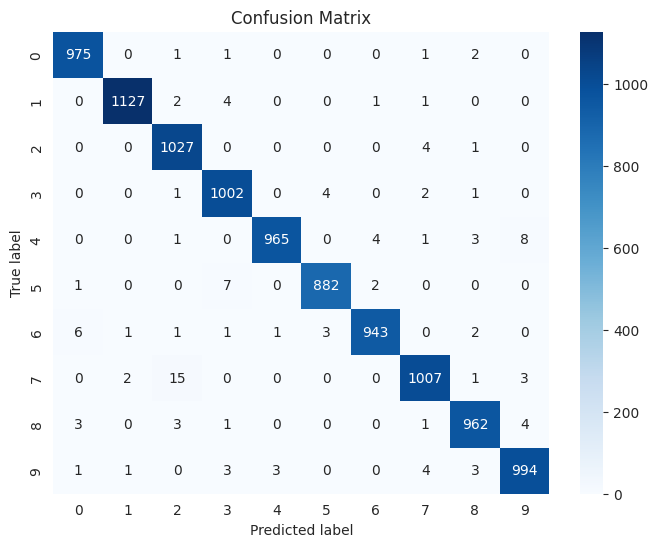

              precision    recall  f1-score   support

           0     0.9888    0.9949    0.9919       980
           1     0.9965    0.9930    0.9947      1135
           2     0.9772    0.9952    0.9861      1032
           3     0.9833    0.9921    0.9877      1010
           4     0.9959    0.9827    0.9892       982
           5     0.9921    0.9888    0.9905       892
           6     0.9926    0.9843    0.9885       958
           7     0.9863    0.9796    0.9829      1028
           8     0.9867    0.9877    0.9872       974
           9     0.9851    0.9851    0.9851      1009

    accuracy                         0.9884     10000
   macro avg     0.9885    0.9883    0.9884     10000
weighted avg     0.9884    0.9884    0.9884     10000



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)


### But the adversary has other plans...

In [40]:
poison_x_test = x_poisoned_test[np.where(is_poison_test == 1)]
poison_y_test = y_poisoned_test[np.where(is_poison_test == 1)]
y_pred = np.argmax(classifier.predict(poison_x_test), axis=1)
y_true = poison_y_test

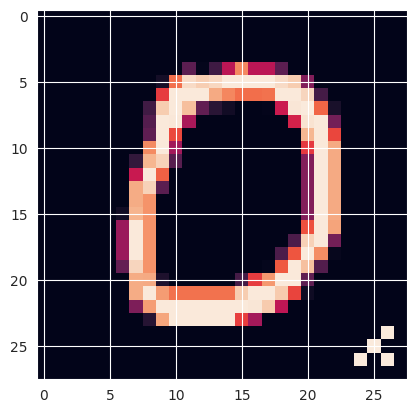

Prediction: 1
True Value: 1


In [41]:
c = 1
i = 3

c_idx = np.where(poison_y_test == c)[0][i]
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()

print(f"Prediction: {y_pred[c_idx]}")
print(f"True Value: {y_true[c_idx]}")

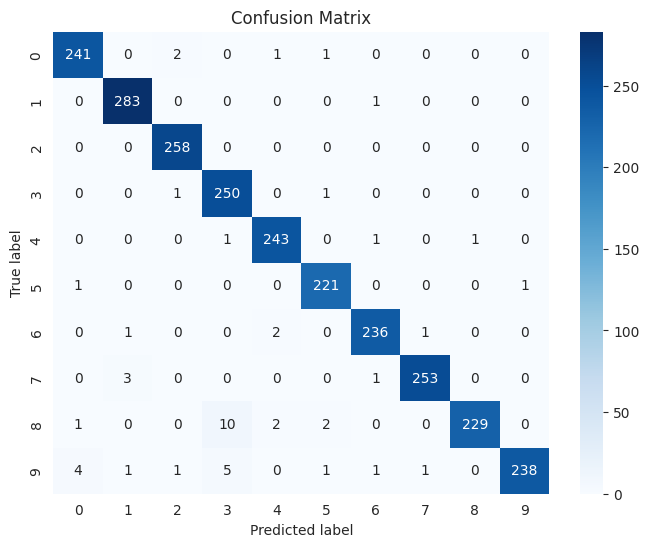

              precision    recall  f1-score   support

           0     0.9757    0.9837    0.9797       245
           1     0.9826    0.9965    0.9895       284
           2     0.9847    1.0000    0.9923       258
           3     0.9398    0.9921    0.9653       252
           4     0.9798    0.9878    0.9838       246
           5     0.9779    0.9910    0.9844       223
           6     0.9833    0.9833    0.9833       240
           7     0.9922    0.9844    0.9883       257
           8     0.9957    0.9385    0.9662       244
           9     0.9958    0.9444    0.9695       252

    accuracy                         0.9804      2501
   macro avg     0.9808    0.9802    0.9802      2501
weighted avg     0.9808    0.9804    0.9804      2501



In [42]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)

### Evaluate accuracy on entire test set

## Detect Poison Using Clustering And Centroid Analysis

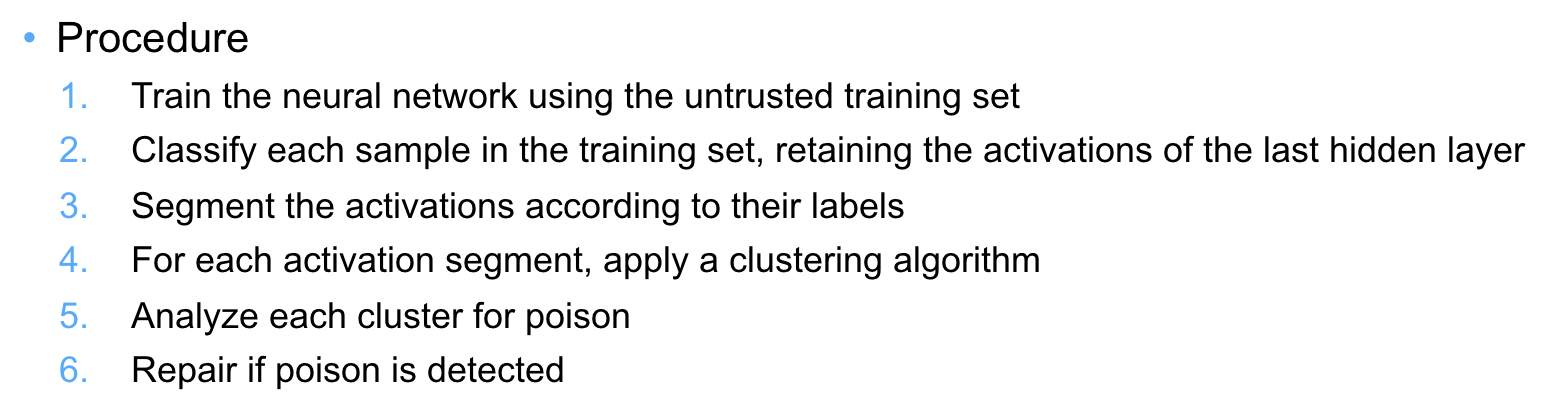

In [43]:
sample_percentage = 0.4
benign_train_indices = np.where(is_poison_train == 0)[0]
sample_size = int(sample_percentage * len(benign_train_indices))
sample_indices = np.random.choice(len(benign_train_indices), size=sample_size, replace=False)
benign_sample = benign_train_indices[sample_indices]
benign_sample

array([62610, 70686, 59247, ..., 73510, 37140, 68395])

## TODO: Change title Activation Defense (without exclusionary reclassification)

In [44]:
# Get the current TensorFlow session
defence = ClusteringCentroidAnalysis(classifier, x_poisoned_train, y_poisoned_train, benign_sample, "dense_1", misclassification_threshold=0.25)


[INFO] Loading variables into CCA...
[INFO] Loading variables into CCA...
[INFO] Extracting submodels...
[INFO] Extracting submodels...
[INFO] CCA object created successfully.
[INFO] CCA object created successfully.


[INFO] Extracting feature representations...
[INFO] Extracting feature representations...


Starting performance measurement for: Poison Detection
2344/2344 [==============================] - 9s 4ms/step


[INFO] Clustering classes...
[INFO] Clustering classes...
[INFO] Unique classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Unique classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Clustering class 0...
[INFO] Clustering class 0...
[INFO] Clustering class 1...
[INFO] Clustering class 1...
[INFO] Clustering class 2...
[INFO] Clustering class 2...
[INFO] Clustering class 3...
[INFO] Clustering class 3...
[INFO] Clustering class 4...
[INFO] Clustering class 4...
[INFO] Clustering class 5...
[INFO] Clustering class 5...
[INFO] Clustering class 6...
[INFO] Clustering class 6...
[INFO] Clustering class 7...
[INFO] Clustering class 7...
[INFO] Clustering class 8...
[INFO] Clustering class 8...
[INFO] Clustering class 9...
[INFO] Clustering class 9...
[INFO] Calculating real centroids...
[INFO] Calculating real centroids...
[INFO] Calculating benign centroids...
[INFO] Calculating benign centroids...
[INFO] Target classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Target classes are: {0, 1, 2,

73/73 [==============================] - 0s 1ms/step


[INFO] Evaluating cluster misclassification...
[INFO] Evaluating cluster misclassification...



Performance Summary for Poison Detection:
Execution Time: 230.22 seconds
duration_seconds: 230.15
cpu_percent_mean: 134.24
cpu_percent_max: 839.20
memory_mb_mean: 3999.64
memory_mb_max: 4154.64
gpu_percent_mean: 33.25
gpu_percent_max: 90.00
gpu_memory_mb_mean: 7772.39
gpu_memory_mb_max: 7951.73


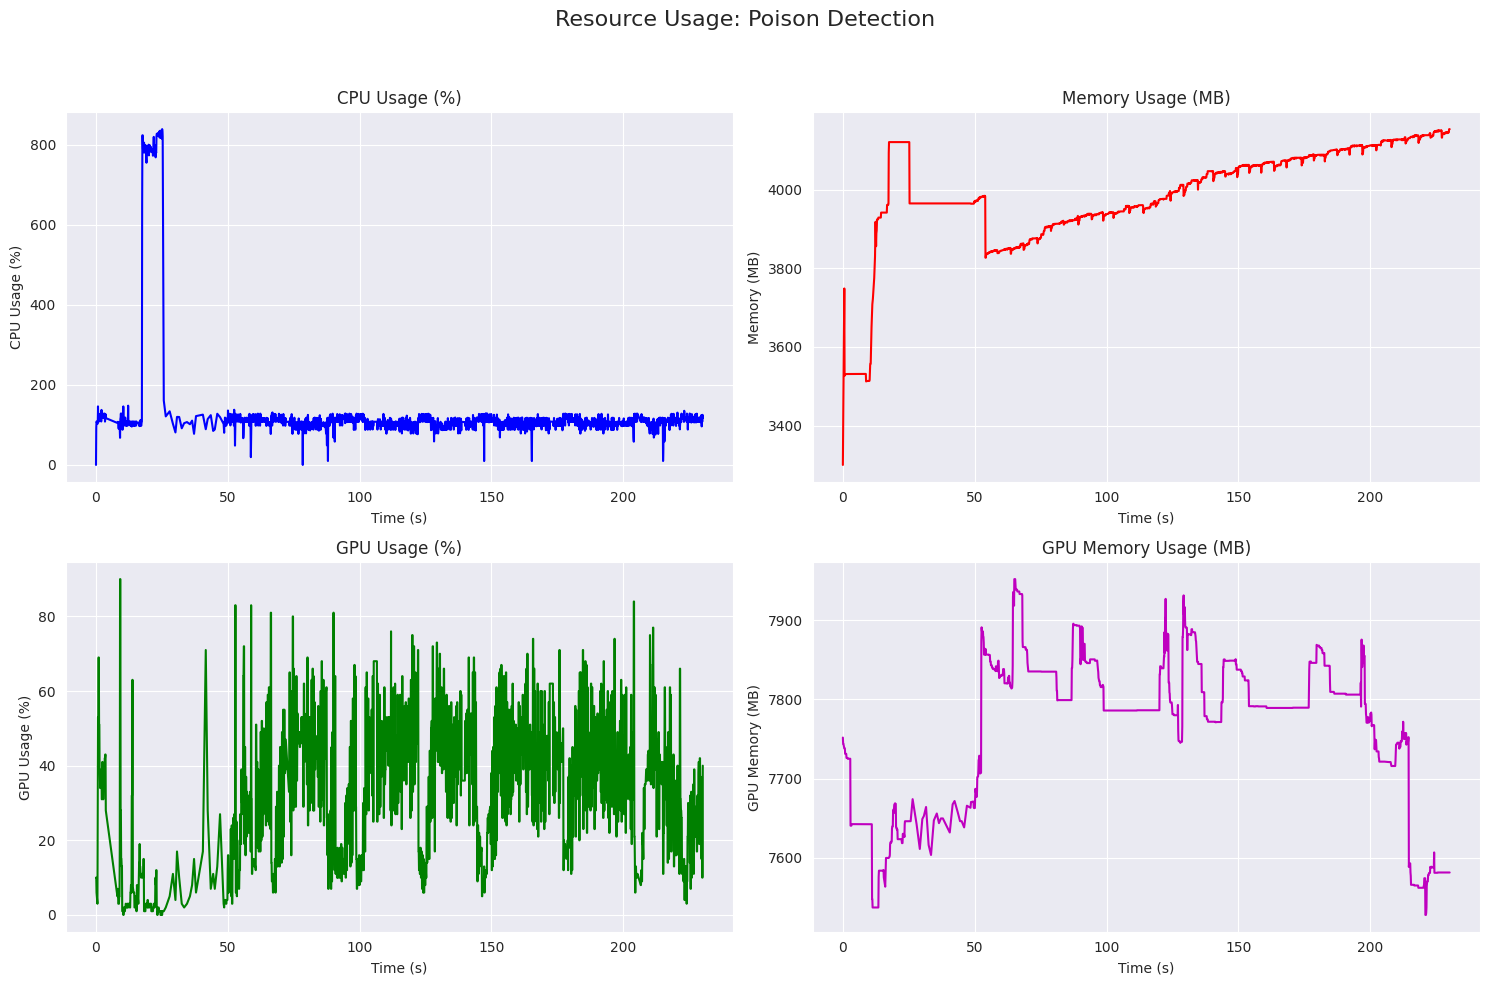

In [45]:
from art.performance_monitor import PerformanceTimer

with PerformanceTimer(task_name="Poison Detection", plot=True, save_data=False) as timer_ccaud:
    report, is_clean_lst = defence.detect_poison()

In [46]:
print(is_clean_lst)
is_clean_lst_int = is_clean_lst.copy()
is_clean_lst_int = is_clean_lst_int.astype('int32')
print(is_clean_lst_int)
print(is_poison_train)

[1. 1. 1. ... 1. 1. 1.]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 1]


In [47]:
is_clean_lst_int_2 = 1 - is_clean_lst_int

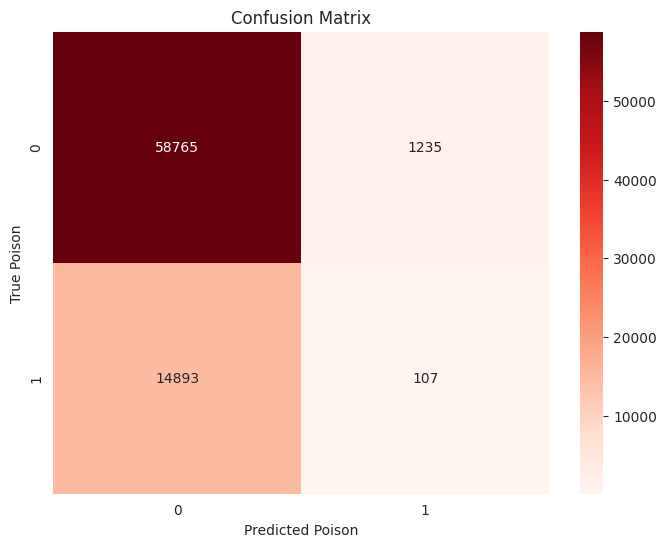

              precision    recall  f1-score   support

           0     0.7978    0.9794    0.8793     60000
           1     0.0797    0.0071    0.0131     15000

    accuracy                         0.7850     75000
   macro avg     0.4388    0.4933    0.4462     75000
weighted avg     0.6542    0.7850    0.7061     75000



In [48]:
poison_confusion_matrix = confusion_matrix(is_poison_train, is_clean_lst_int_2)
plt.figure(figsize=(8, 6))

sns.heatmap(poison_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Poison")
plt.ylabel("True Poison")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(is_poison_train, is_clean_lst_int_2, digits=4)
print(report)

In [49]:
print("Analysis completed. Report:")
pprint.pprint(report)

Analysis completed. Report:
('              precision    recall  f1-score   support\n'
 '\n'
 '           0     0.7978    0.9794    0.8793     60000\n'
 '           1     0.0797    0.0071    0.0131     15000\n'
 '\n'
 '    accuracy                         0.7850     75000\n'
 '   macro avg     0.4388    0.4933    0.4462     75000\n'
 'weighted avg     0.6542    0.7850    0.7061     75000\n')


In [50]:
# Add a cell to analyze the performance results
performance_summary = timer_ccaud.get_summary()
print("\nDetailed Performance Metrics:")
for metric, value in performance_summary.items():
    print(f"  {metric}: {value:.2f}")

# Optionally, you can save the detailed data for further analysis
performance_data = timer_ccaud.get_data()



Detailed Performance Metrics:
  duration_seconds: 230.15
  cpu_percent_mean: 134.24
  cpu_percent_max: 839.20
  memory_mb_mean: 3999.64
  memory_mb_max: 4154.64
  gpu_percent_mean: 33.25
  gpu_percent_max: 90.00
  gpu_memory_mb_mean: 7772.39
  gpu_memory_mb_max: 7951.73


### Evaluate Defense

In [51]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 1467, 'numerator': 1443, 'rate': 98.36},
 'FalsePositive': {'denominator': 6024, 'numerator': 105, 'rate': 1.74},
 'TrueNegative': {'denominator': 6024, 'numerator': 5919, 'rate': 98.26},
 'TruePositive': {'denominator': 1467, 'numerator': 24, 'rate': 1.64}}
class_1
{'FalseNegative': {'denominator': 1690, 'numerator': 1660, 'rate': 98.22},
 'FalsePositive': {'denominator': 6665, 'numerator': 120, 'rate': 1.8},
 'TrueNegative': {'denominator': 6665, 'numerator': 6545, 'rate': 98.2},
 'TruePositive': {'denominator': 1690, 'numerator': 30, 'rate': 1.78}}
class_2
{'FalseNegative': {'denominator': 1479, 'numerator': 1462, 'rate': 98.85},
 'FalsePositive': {'denominator': 5966, 'numerator': 94, 'rate': 1.58},
 'TrueNegative': {'denominator': 5966, 'numerator': 5872, 'rate': 98.42},
 'TruePositive': {'denominator': 1479, 'numerator': 17, 'rate': 1.15}}
class_3
{'FalseNegative': {'denomi

### Get clustering and reduce activations to 3 dimensions using PCA

In [52]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

AttributeError: 'ClusteringCentroidAnalysis' object has no attribute 'cluster_activations'

### Visualize activations colored by clustering

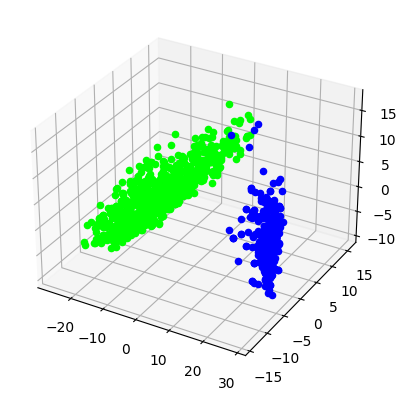

In [18]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


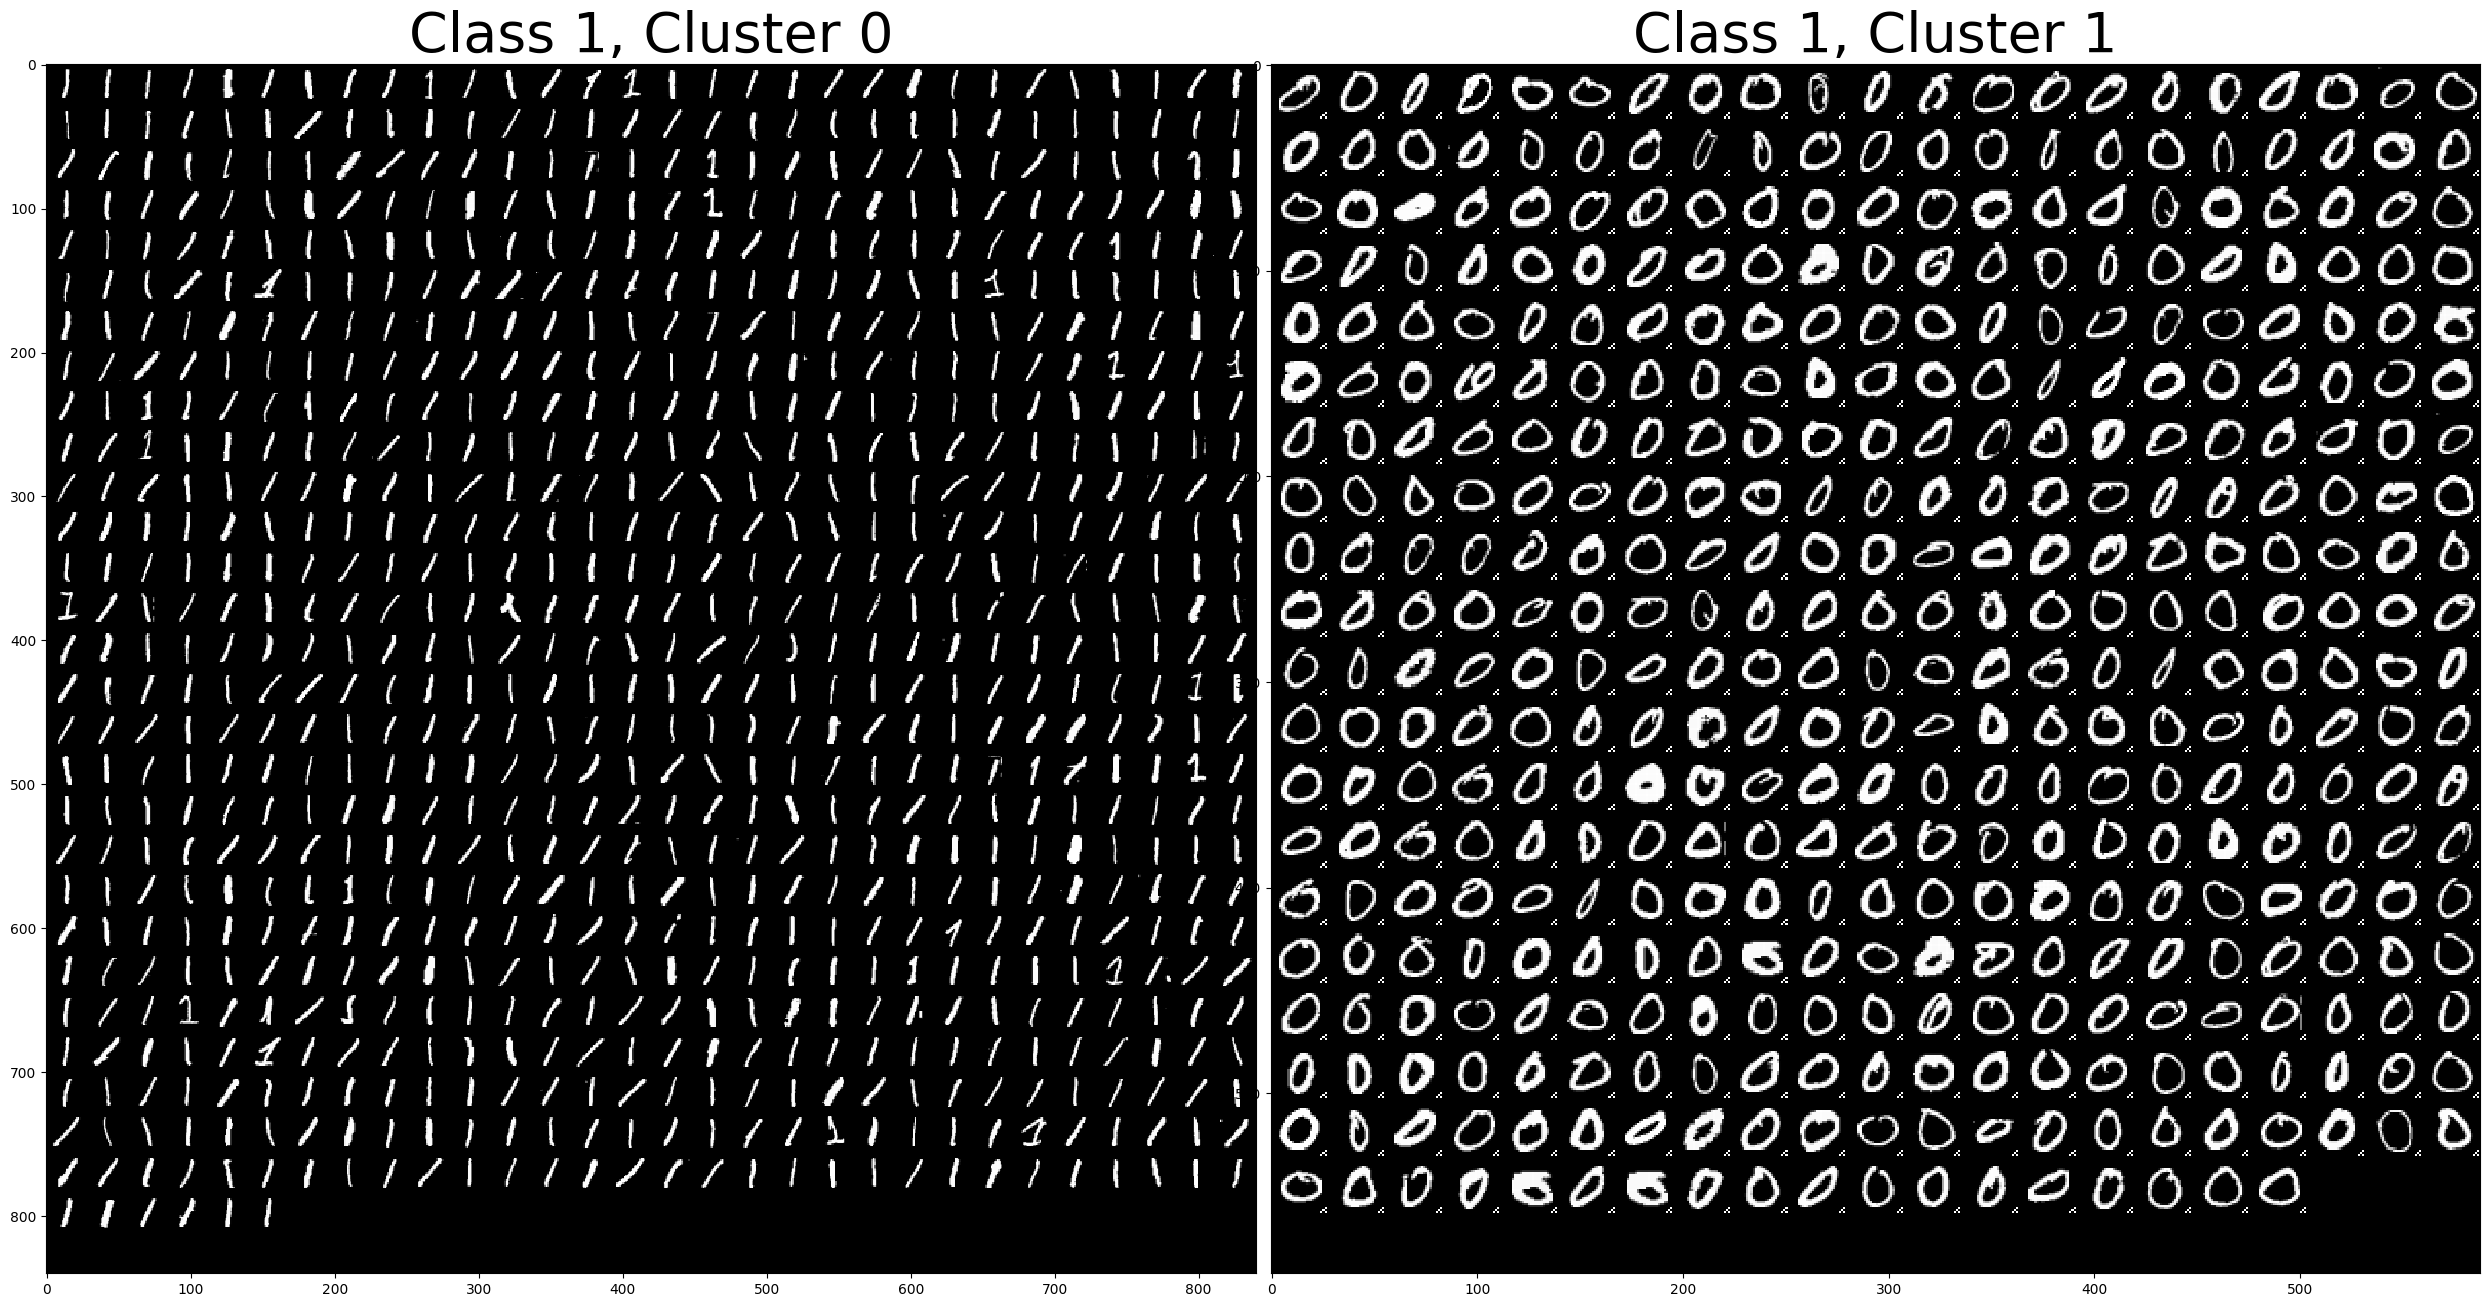

In [19]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q + 1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


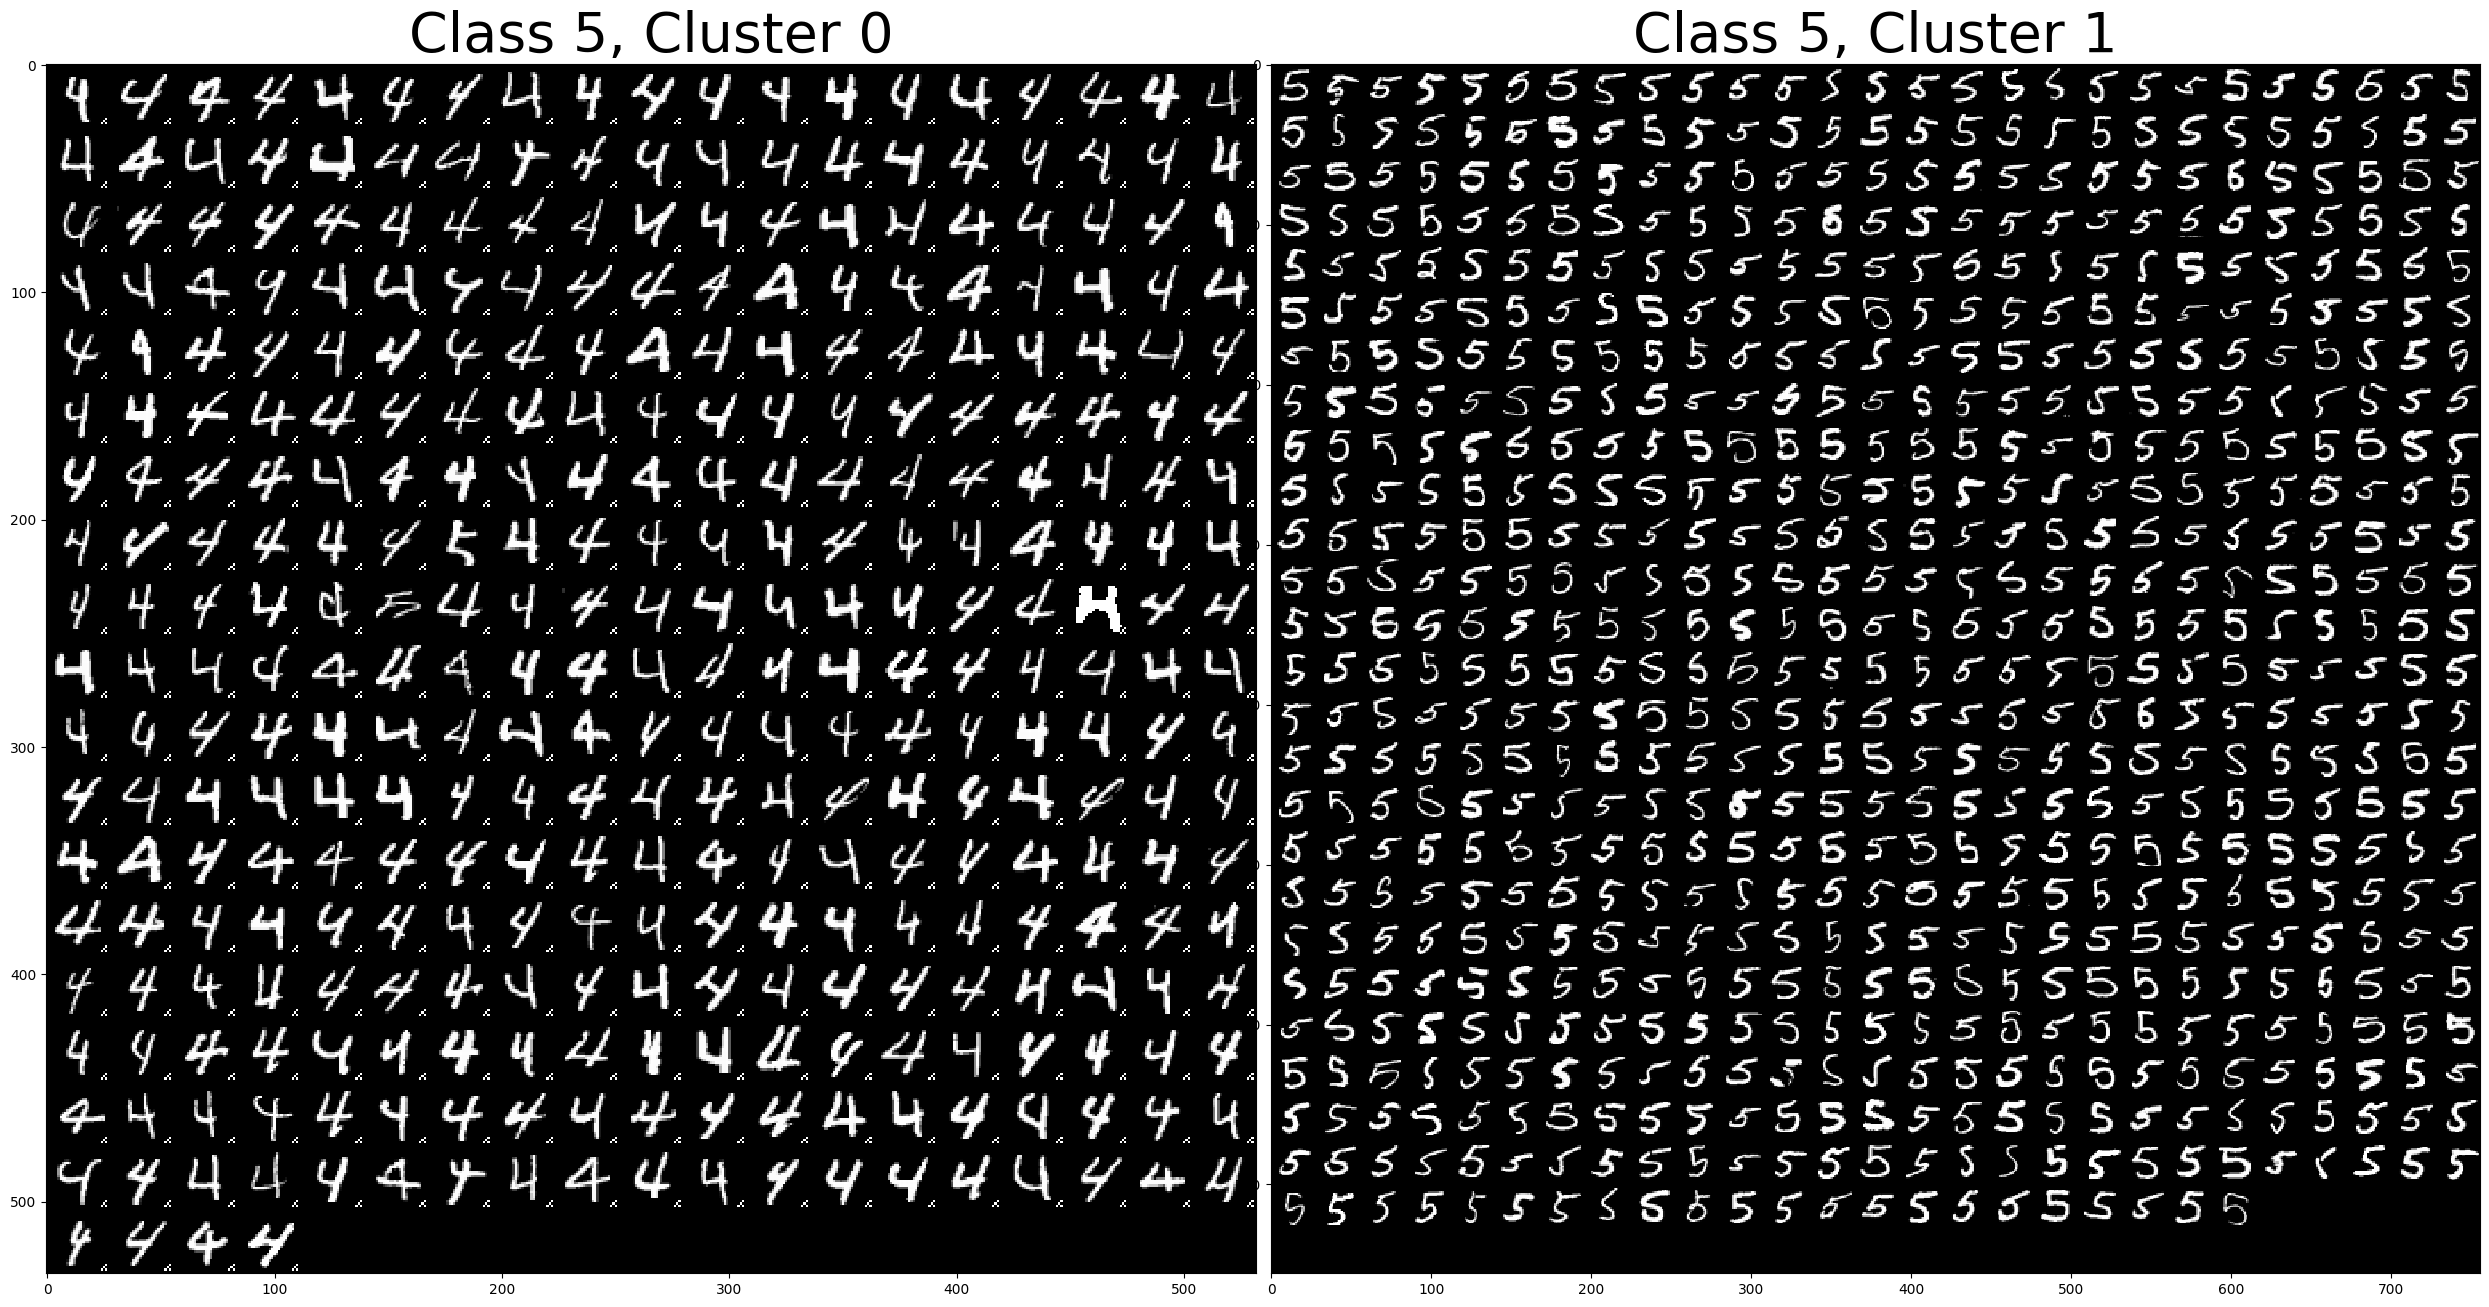

In [20]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)

## Activation Defense (with exclusionary reclassification)

In [21]:
# Here we use exclusionary reclassification, which will also relabel the data internally
defence = ActivationDefence(classifier, x_train, y_train, ex_re_threshold=1)

In [22]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")

[INFO] Getting activations
[INFO] Performing Exclusionary Reclassification with a threshold of 1
[INFO] Data will be relabelled internally. Access the y_train_relabelled attribute to get new labels
[INFO] Inferred 7 hidden layers on Keras classifier.


Train on 7482 samples
Epoch 1/20
7482/7482 [==============================] - 5s 639us/sample - loss: 0.5537 - accuracy: 0.8262
Epoch 2/20
7482/7482 [==============================] - 5s 604us/sample - loss: 0.1599 - accuracy: 0.9526
Epoch 3/20
7482/7482 [==============================] - 5s 623us/sample - loss: 0.1074 - accuracy: 0.9642
Epoch 4/20
7482/7482 [==============================] - 5s 606us/sample - loss: 0.0814 - accuracy: 0.9729
Epoch 5/20
7482/7482 [==============================] - 5s 608us/sample - loss: 0.0612 - accuracy: 0.9797
Epoch 6/20
7482/7482 [==============================] - 5s 610us/sample - loss: 0.0536 - accuracy: 0.9844
Epoch 7/20
7482/7482 [==============================] - 5s 609us/sample - loss: 0.0476 - accuracy: 0.9862
Epoch 8/20
7482/7482 [==============================] - 5s 660us/sample - loss: 0.0368 - accuracy: 0.9884
Epoch 9/20
7482/7482 [==============================] - 5s 613us/sample - loss: 0.0352 - accuracy: 0.9876
Epoch 10/20
7482/7482 [=

In [23]:
print("Analysis completed. Report:")
pprint.pprint(report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ExRe_Score': 0.005405405405405406,
                           'Suspected_Source_class': 9,
                           'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ExRe_Score': 0.0,
                           'Suspected_Source_class': 0,
                           'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ExRe_Score': 0.011235955056179775,
                           'Suspected_Source_class': 1,
                           'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.66,
            

### Evaluate Defence

In [24]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 364, 'numerator': 236, 'rate': 64.84},
 'FalsePositive': {'denominator': 758, 'numerator': 246, 'rate': 32.45},
 'TrueNegative': {'denominator': 758, 'numerator': 512, 'rate': 67.55},
 'TruePositive': {'denominator': 364, 'numerator': 128, 'rate': 35.16}}
class_1
{'FalseNegative': {'denominator': 416, 'numerator': 264, 'rate': 63.46},
 'FalsePositive': {'denominator': 847, 'numerator': 265, 'rate': 31.29},
 'TrueNegative': {'denominator': 847, 'numerator': 582, 'rate': 68.71},
 'TruePositive': {'denominator': 416, 'numerator': 152, 'rate': 36.54}}
class_2
{'FalseNegative': {'denominator': 381, 'numerator': 250, 'rate': 65.62},
 'FalsePositive': {'denominator': 698, 'numerator': 232, 'rate': 33.24},
 'TrueNegative': {'denominator': 698, 'numerator': 466, 'rate': 66.76},
 'TruePositive': {'denominator': 381, 'numerator': 131, 'rate': 34.38}}
class_3
{'FalseNegative': {'denominator'

### Get clustering and reduce activations to 3 dimensions using PCA

In [25]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

### Visualize activations colored by clustering

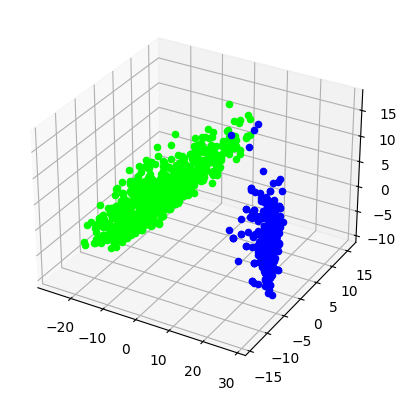

In [26]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


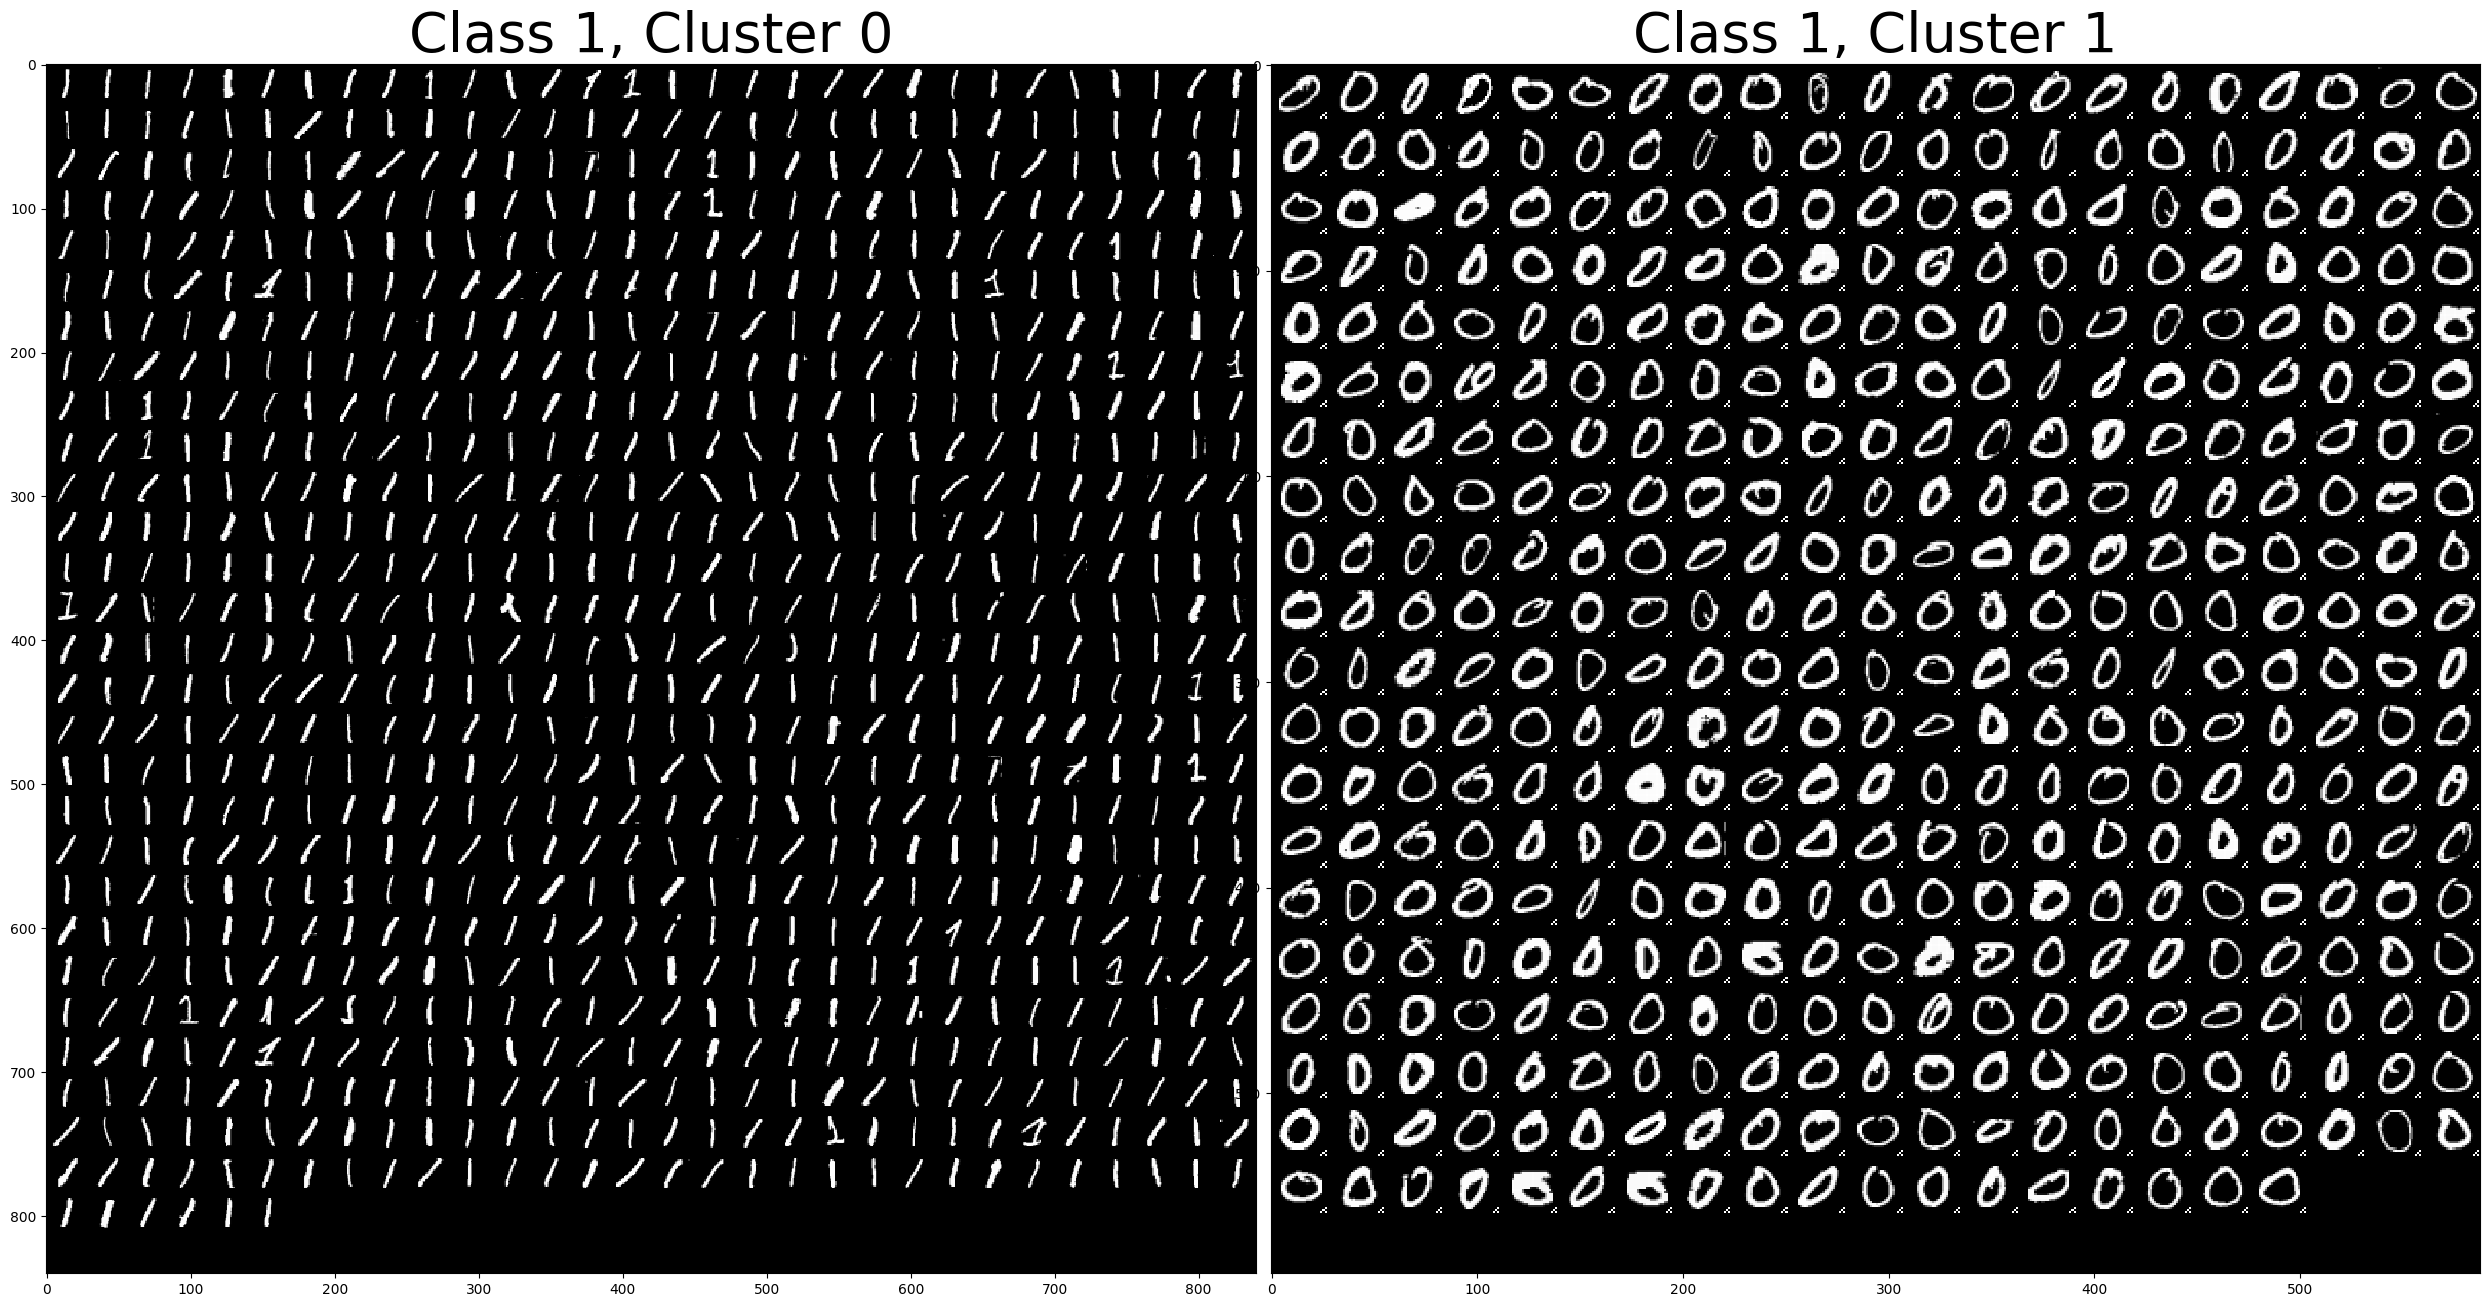

In [27]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


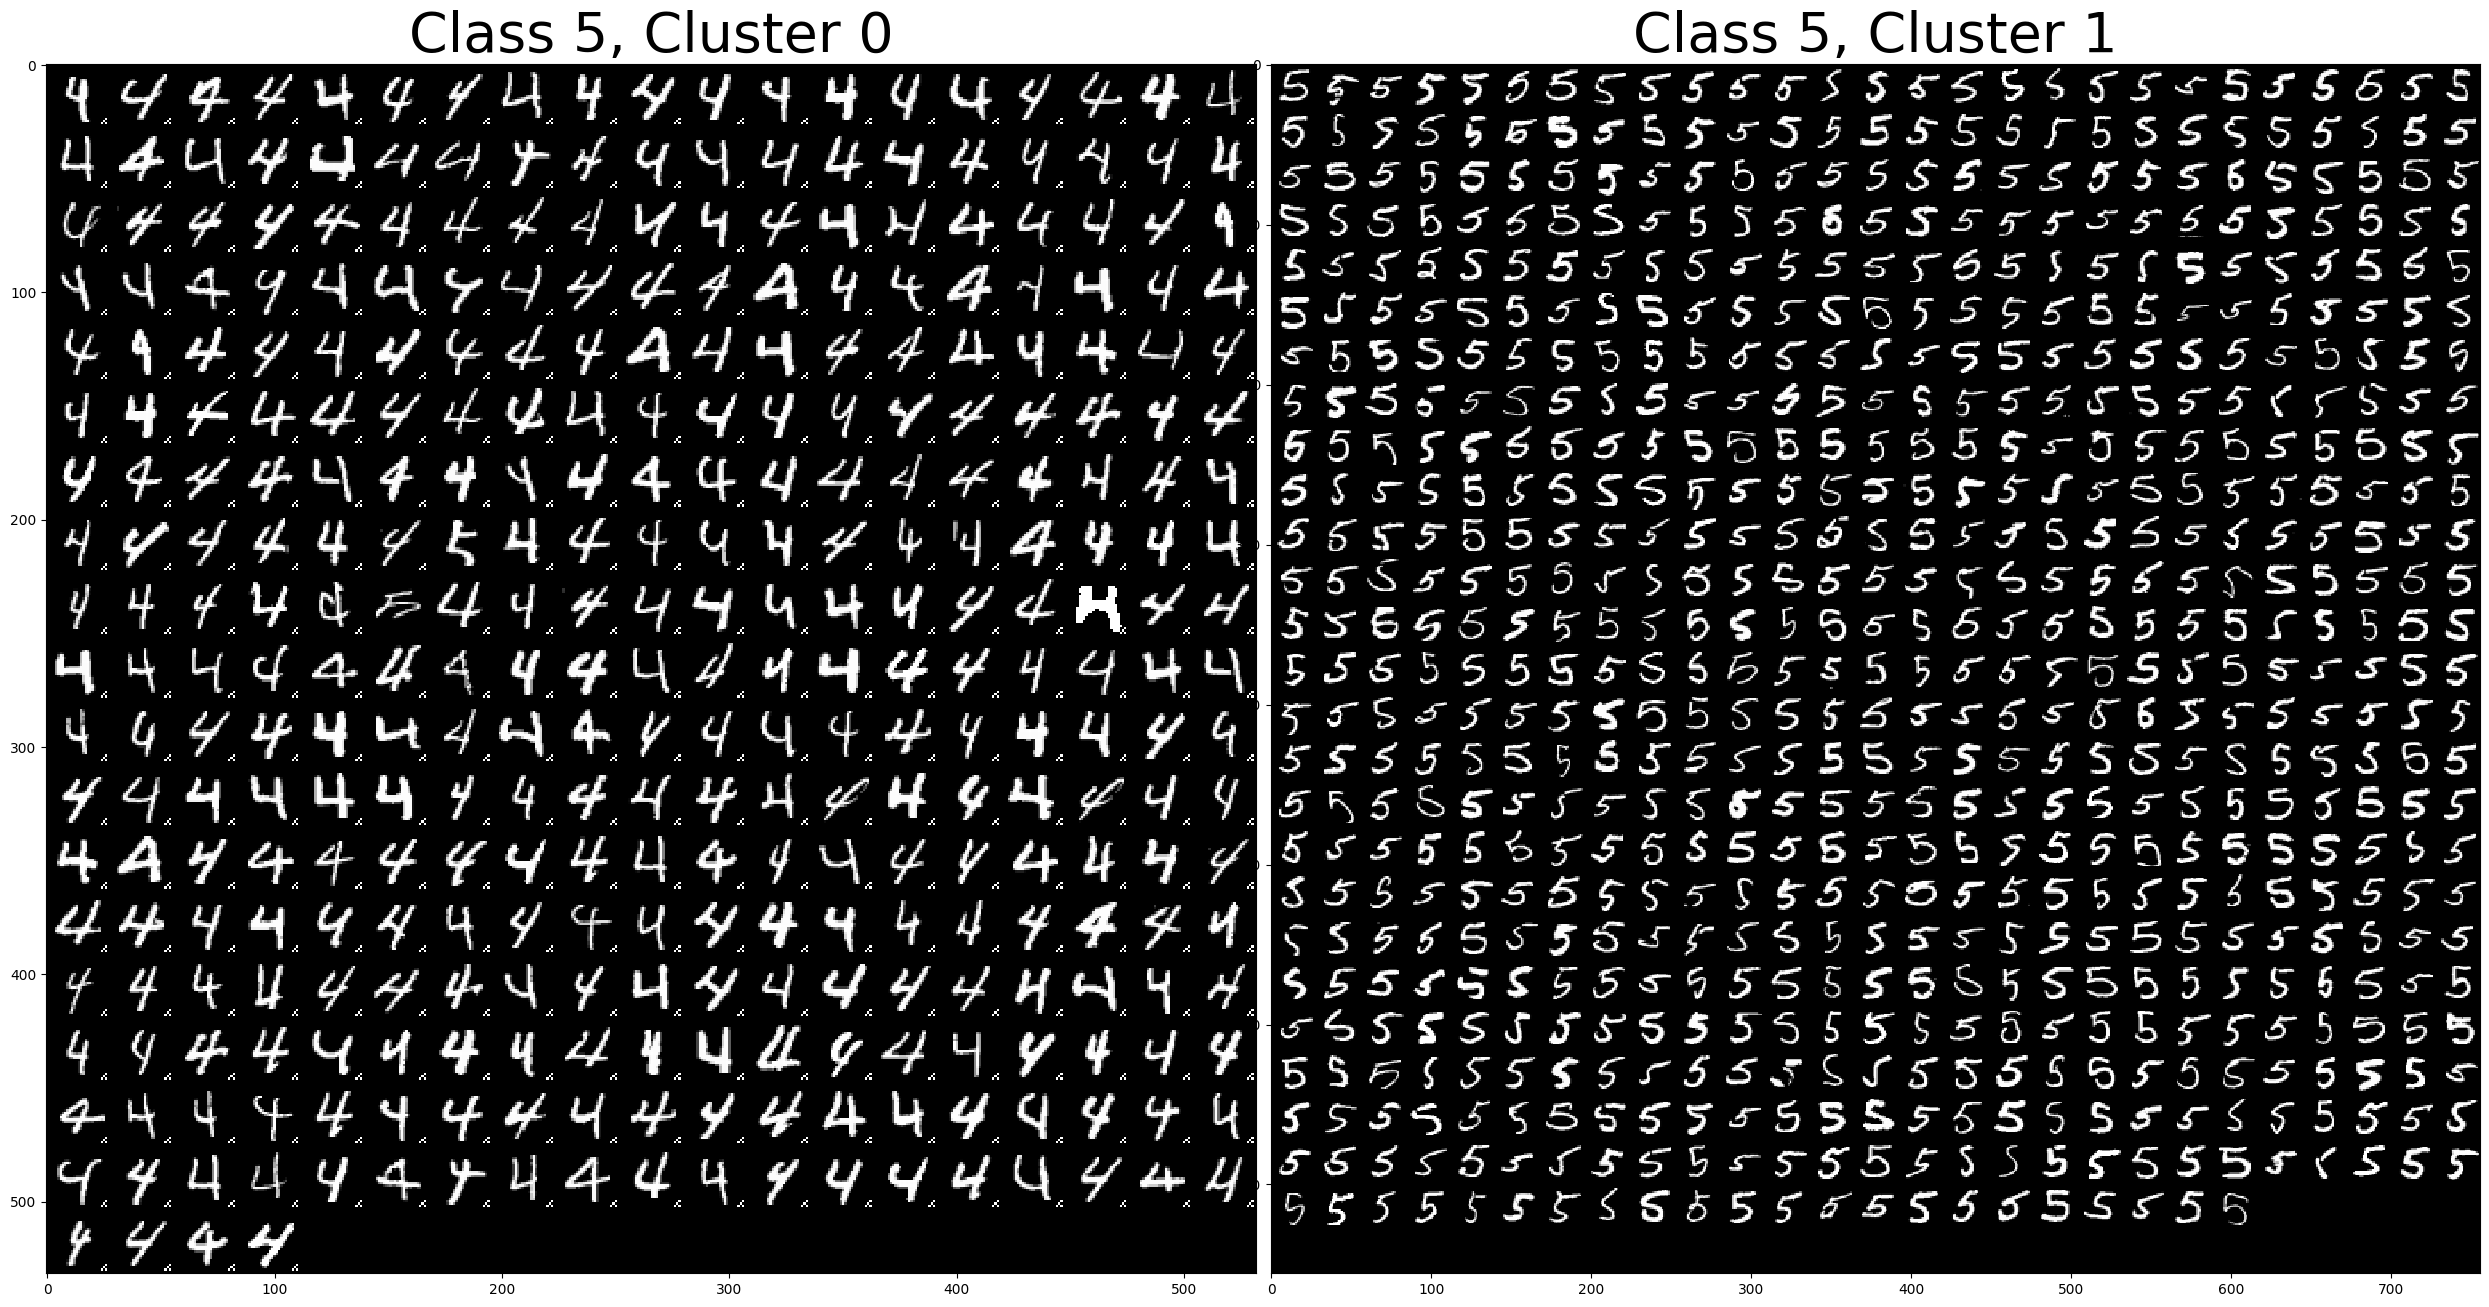

In [28]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)